In [54]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pybedtools
import pandas as pd
from collections import defaultdict
from biodata.delimited import DelimitedWriter
import numpy as np
import sys
import pyBigWig
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
from pathlib import Path
import matplotlib.colors as mcolors
from biodatatools.utils.common import json_load
from scipy import stats

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [3]:
sys.path.append(str(Path.cwd().parent))
import utils

In [4]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2  = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

# Accessibility: PRO-cap (+) vs. PRO-cap (-)

## Get PRO-cap (+) and PRO-cap (-) regions

In [5]:
s = "SC5"
beds = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_beds.json")
b1 = pybedtools.BedTool(beds[s][0])
b2 = pybedtools.BedTool(beds[s][1])
b_merged = b1.cat(b2)

In [6]:
# ATAC-seq peaks (original peak boundary; subpeaks are assigned to the same category)
# PRO-cap (+): 1-bp overlap with PRO-cap peaks
# PRO-cap (-): no overlaps

b = pybedtools.BedTool(f"{PROJECT_DIR_o}chrombpnet/finemo/logs.seq_contrib.counts.input_regions.modisco.GSE267154.narrowPeak")
labels = {"overlap": set([tuple(i.fields[:3]) for i in b.intersect(b_merged, u=True)]),
		  "nonoverlap": set([tuple(i.fields[:3]) for i in b.intersect(b_merged, v=True)])
		 }

In [7]:
for k in labels:
	print(k, len(labels[k]))

overlap 30786
nonoverlap 129318


## Metaplots

In [8]:
# Check ATAC-seq signals in regions with and without overlapping PRO-cap peaks

for k in labels:
	outputfile = f"{PROJECT_DIR_o}chrombpnet/finemo/{k}.bed"
	with DelimitedWriter(outputfile) as dw:
		for e in labels[k]:
			dw.write(e)
	pybedtools.BedTool(outputfile).sort().saveas(outputfile)

In [9]:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE267154

bws = {"ATAC": f"{PROJECT_DIR_d2}GEO/GSE267154/GSE267154_H1.Tn5shift.insertion.coverage.bigwig"
		}
ms = list(bws.keys())

In [11]:
# 1kb region anchored on the peak center

df_features = {}
use_strand = False
for k in labels:
	bed = f"{PROJECT_DIR_o}chrombpnet/finemo/{k}.bed"
	all_regions = BEDXReader.read_all(GenomicCollection, bed)
	index = [f"{r.chrom}_{r.chromStart}_{r.chromEnd}" for r in all_regions]
	for m in bws:
		df_features[(m,k)] = pd.DataFrame(bpm.generate_signal_profile(all_regions, BigWigIReader(bws[m]), fixed_size=1001, use_strand=use_strand), index=index)

In [12]:
df_reformat = {}
for k in df_features:
	df = df_features[k].reset_index()
	df_reformat[k] = pd.melt(df,
						  id_vars="index",
						  value_vars=list(df.columns[1:]),
						  var_name="Position",
						  value_name="Feature"
						  )

In [14]:
df_metaplots = {}
for m in ms:
	dfs = []
	for k in labels:
		df = df_reformat[(m, k)].copy()
		df["Label"] = k
		dfs.append(df)
	df_metaplots[m] = pd.concat(dfs).reset_index(drop=True)		

In [15]:
for m in ms:
	maxs = []
	mins = []
	df = df_metaplots[m]
	for k in labels:
		maxs.append(df[df["Label"]==k].groupby("Position")["Feature"].mean().max())
		mins.append(df[df["Label"]==k].groupby("Position")["Feature"].mean().min())
	print(m, max(maxs), min(mins))

ATAC 0.8753004612486195 0.0891987194358094


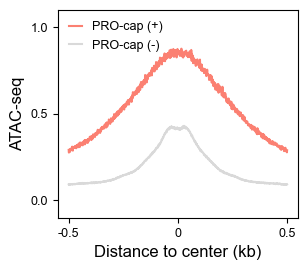

In [25]:
fig, ax = plt.subplots(figsize=(3.1,2.7))
test = False
utils.generate_feature_metaplot(df_metaplots[m], ["#fb8072", "#d9d9d9"], ["overlap", "nonoverlap"], ax, test, errorbar=None)
ax.legend(["PRO-cap (+)", "PRO-cap (-)"], fontsize=sfontsize, 
		  frameon=False, loc="upper left", handlelength=1)
ax.set_ylabel("ATAC-seq", fontsize=bfontsize)
ax.set_yticks([0,0.5,1])
ax.set_ylim([-0.1,1.1])

ax.set_xlabel("Distance to center (kb)", fontsize=bfontsize)
ax.set_xticks([0,500,1000])
ax.set_xticklabels([-0.5,0,0.5])

ax.tick_params(labelsize=sfontsize)
plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig2a.pdf", bbox_inches="tight", transparent=True)

# Motif occurrences

In [ ]:
# Identify fraction of PRO-cap peaks with motifs contributing to transcritpion and fraction of ATAC-seq peaks with motifs contributing to accessibility.

In [17]:
# Subpeaks are assigned to the same category

mapping = defaultdict(set)
for i in b:
	mapping[tuple(i.fields[:3])].add(i.fields[3])

In [18]:
df_motifs = {"procapnet": pd.read_table(f"{PROJECT_DIR_o}procapnet/finemo/{s}/procapnet_scores/merged_hits.tsv"),
			 "chrombpnet": pd.read_table(f"{PROJECT_DIR_o}chrombpnet/finemo/merged_hits.tsv")
			}

In [19]:
motif_order = ["SP", "ETS", "NFY", "NRF1", "CREB", "AP1", "ZBTB33", "THAP11-ZNF143", "TATA", "YY1", "SRF", "REST", "RFX4", "RFX5", "SIX", "CTCF", "TEAD", "SOX", "POU5F1-SOX2", "ZIC"]

In [20]:
results = []
for motif in motif_order:
	# ProCapNet
	df = df_motifs["procapnet"]
	n_peaks_with_motif = len(set(df[df["motif"]==motif]["peak_name"]))
	n_total_peaks = len(pybedtools.BedTool(f"{PROJECT_DIR_o}procapnet/finemo/{s}/input.bed"))
	row = [n_peaks_with_motif/n_total_peaks]

	# ChromBPNet
	df = df_motifs["chrombpnet"]
	for k in labels:
		peak_names_included = [e2 for e in labels[k] for e2 in mapping[e]]
		n_peaks_with_motif = len(set(df[(df["peak_name"].isin(peak_names_included)) & (df["motif"]==motif)]["peak_name"]))
		row.append(n_peaks_with_motif/len(peak_names_included))
	results.append(row)
df_frac = pd.DataFrame(results, columns=["PRO-cap", "PRO-cap (+)", "PRO-cap (-)"], index=motif_order)
df_frac.head(2)

,PRO-cap,PRO-cap (+),PRO-cap (-)
SP,0.806734,0.854827,0.531124
ETS,0.854380,0.779009,0.399169


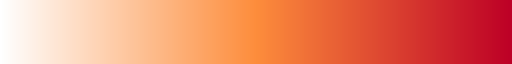

In [21]:
colors = [(0.0, "#ffffff"), (0.5, "#fd8d3c"), (1, "#bd0026")] 
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
cmap

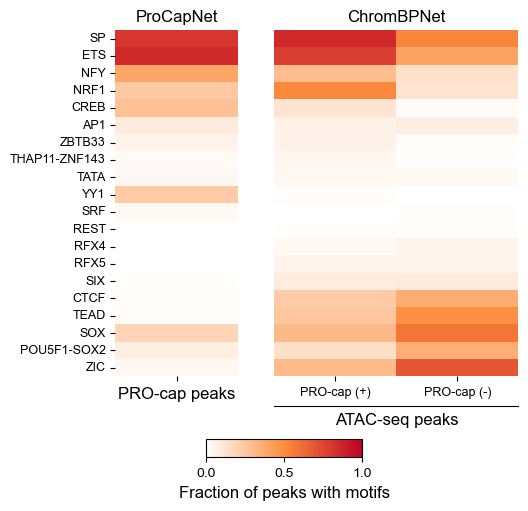

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(5.2,4.5), gridspec_kw={'width_ratios': [1, 2]})
# ProCapNet
g = sns.heatmap(df_frac[["PRO-cap"]], vmin=0, vmax=1, yticklabels=True, cmap=cmap, cbar=False, ax=ax[0])
g.set_title("ProCapNet", fontsize=bfontsize)
g.set_xticklabels(["PRO-cap peaks"], fontsize=bfontsize)
g.tick_params(axis="y", labelsize=sfontsize)

# ChromBPNet
g = sns.heatmap(df_frac[["PRO-cap (+)", "PRO-cap (-)"]], vmin=0, vmax=1, yticklabels=False, cmap=cmap, ax=ax[1])
g.set_title("ChromBPNet", fontsize=bfontsize)
g.tick_params(axis="x", labelsize=sfontsize)

ax[1].plot([0, 2], [len(df_frac)+1.7, len(df_frac)+1.7], color="#000000", linewidth=lw, clip_on=False)
ax[1].text(x=1, y=len(df_frac)+2.5, s="ATAC-seq peaks", ha="center", va="center", fontsize=bfontsize)

g.collections[0].colorbar.remove()
cbar_ax = fig.add_axes([0.3, -0.07, 0.3, 0.04])
cbar = plt.colorbar(g.collections[0], cax=cbar_ax, orientation="horizontal")
fig.text(0.45, -0.15, "Fraction of peaks with motifs", ha='center', va='center', fontsize=bfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig2d.pdf", bbox_inches="tight", transparent=True)

# Contribution scores at individual motif instances

## Get the set of motif instances

In [27]:
df_motifs["chrombpnet_procap"] = pd.read_table(f"{PROJECT_DIR_o}procapnet/finemo/{s}/chrombpnet_scores/merged_hits.tsv")

In [34]:
df_merged = pd.concat([df_motifs["procapnet"], df_motifs["chrombpnet_procap"]], ignore_index=True)
df_merged = df_merged.sort_values(['motif', 'peak_id', 'chr', 'start'])
df_merged.head(2)

,chr,start,end,start_untrimmed,end_untrimmed,motif_name,hit_coefficient,hit_coefficient_global,hit_correlation,hit_importance,strand,peak_name,peak_id,motif
140,chr1,967005,967018,966998,967028,pos_patterns.pattern_9,10.293246,0.000107,0.789285,0.107811,+,chr1_966894_967159,20,AP1
537222,chr1,967006,967015,966995,967025,pos_patterns.pattern_12,4.740517,0.000085,0.929002,0.051769,-,chr1_966894_967159,20,AP1


In [42]:
# We compare the contribution scores from each model at individual motif instances; for the same motif type and same peak, we merge the motif boundary between motif calls from this two groups

def merge_intervals(df):
    merged_list = []
    for (motif, peak_id), group in df.groupby(['motif', 'peak_id']):
        current = None
        for idx, row in group.iterrows():
            if current is None:
                current = row[["chr", "start", "end", "peak_id", "peak_name", "motif"]].copy()
            else:
                if row['chr'] == current['chr'] and row['start'] <= current['end']:
                    current['end'] = max(current['end'], row['end'])
                else:
                    merged_list.append(current)
                    current = row[["chr", "start", "end", "peak_id", "peak_name", "motif"]].copy()
        if current is not None:
            merged_list.append(current)

    return pd.DataFrame(merged_list)

In [43]:
final_df = merge_intervals(df_merged)
final_df.head(2)

,chr,start,end,peak_id,peak_name,motif
140,chr1,967005,967018,20,chr1_966894_967159,AP1
252,chr1,1019238,1019251,36,chr1_1019552_1019785,AP1


In [45]:
# Peak ID, motif start, motif end

motif_pos = defaultdict(list)
for motif in motif_order:
	df = final_df[final_df["motif"]==motif]
	for _, row in df.iterrows():
		chrom, start, end = row["peak_name"].split("_")
		center = (int(start)+int(end))//2
		rel_start = row["start"]-(center-2114//2)
		rel_end = row["end"]-(center-2114//2)
		motif_pos[motif].append([row["peak_id"], rel_start, rel_end])

## Pairwise comparison

In [39]:
model_type = "strand_merged_umap"
scores = {"procapnet": np.load(f"{PROJECT_DIR_o}procapnet/deepshap_out/{s}/{model_type}/merged/all_counts_deepshap.npy"),
		  "chrombpnet": np.load(f"{PROJECT_DIR_o}procapnet/finemo/{s}/chrombpnet_scores/contrib/GSE267154.counts_scores.mean.npy")
		 }

In [50]:
# Get the sum of contribution scores in each motif instance from both models

results = []
for motif, motif_data in motif_pos.items():
    procapnet_sums = [scores["procapnet"][n, :, start:end].sum() for n, start, end in motif_data]
    chrombpnet_sums = [scores["chrombpnet"][n, :, start:end].sum() for n, start, end in motif_data]

    results.extend(
        zip([motif] * len(motif_data),
            procapnet_sums,
            chrombpnet_sums
        )
    )
df_scores = pd.DataFrame(results, columns=["motif", "procapnet score", "chrombpnet score"])
df_scores.head(2)

,motif,procapnet score,chrombpnet score
0,SP,0.005033,0.021698
1,SP,0.042631,0.051910


In [90]:
def plot_one_motif(df, motif, ax, xlabel, ylabel, xlims=None, ylims=None, same=True):
	g = sns.scatterplot(data=df, x="chrombpnet score", y="procapnet score", alpha=0.5, s=0.5, ax=ax)
	g.set_title(motif, fontsize=bfontsize)
	g.spines[["top","right"]].set_visible(False)
	
	corr, _ = stats.pearsonr(list(df["chrombpnet score"]), list(df["procapnet score"]))
	g.text(s=f"r={round(corr, 2)}", x=0.8, y=0.8, fontsize=sfontsize, color="red")

	if xlabel:
		g.set_xlabel("Contribution score \n(ChromBPNet)", fontsize=bfontsize)
	else:
		g.set_xlabel("")

	if ylabel:
		g.set_ylabel("Contribution score \n(ProCapNet)", fontsize=bfontsize)
		g.yaxis.set_label_coords(-0.2,0.5)
	else:
		g.set_ylabel("")

	g.set_xticks([0,1])
	g.set_xlim([-0.3,1.3])
	g.set_yticks([0,1])
	g.set_ylim([-0.3,1.3])
	g.tick_params(labelsize=sfontsize)

In [64]:
candidate_motifs = ["NRF1", "CREB",
					"SRF", "YY1",
					"CTCF", "SIX"
				   ]

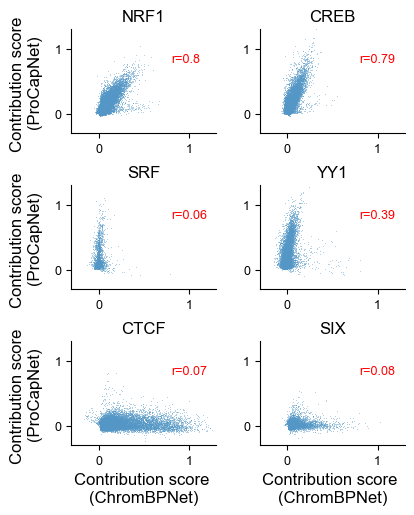

In [91]:
fig, ax = plt.subplots(3,2,figsize=(4.3,5.4))

for motif in candidate_motifs:
	row = candidate_motifs.index(motif) // 2
	col = candidate_motifs.index(motif) % 2
	xlabel = True if row == 2 else False
	ylabel = True if col == 0 else False
	plot_one_motif(df_scores[df_scores["motif"]==motif], motif, ax[row,col], xlabel, ylabel)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig2e.png", bbox_inches="tight", dpi=300, transparent=True)